 # Thuật toán Decision Tree - CART

# 1. Import thư viện

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from graphviz import Digraph

*Giải thích*

* numpy: Được sử dụng để xử lý các phép toán ma trận và tính toán hiệu quả.

*   matplotlib.pyplot: Dùng để vẽ biểu đồ, giúp trực quan hóa dữ liệu và kết quả.
* pandas: đọc dữ liệu từ file CSV.

*  KFold: chia dữ liệu thành các tập con (folds) phục vụ cho quá trình cross-validation.




# 2.Định nghĩa lớp DecisionTree

In [65]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return np.mean(y)

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return (best_feature, best_threshold, left_tree, right_tree)

    def _predict_one(self, x, tree):
        if not isinstance(tree, tuple):
            return tree
        feature, threshold, left_tree, right_tree = tree
        if x[feature] <= threshold:
            return self._predict_one(x, left_tree)
        else:
            return self._predict_one(x, right_tree)

    def _best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_mse = float('inf')

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                mse = self._calculate_mse(y[left_indices], y[right_indices])

                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_mse(self, left_y, right_y):
        left_mse = np.mean((left_y - np.mean(left_y)) ** 2) if len(left_y) > 0 else 0
        right_mse = np.mean((right_y - np.mean(right_y)) ** 2) if len(right_y) > 0 else 0
        return (len(left_y) * left_mse + len(right_y) * right_mse) / (len(left_y) + len(right_y))


*Giải thích*

*  **Khởi tạo lớp DecisionTree.** :

*  max_depth: Tham số này xác định độ sâu tối đa của cây. Nếu không đặt, cây có thể phát triển không giới hạn cho đến khi tất cả các mẫu đều được phân loại chính xác
*  self.tree: Dùng để lưu trữ cấu trúc cây sau khi được xây dựng.





*   **Huấn luyện mô hình (fit)** :Phương thức này nhận đầu vào là X (mảng các đặc trưng) và y (mảng nhãn). Nó gọi hàm _build_tree để xây dựng cây quyết định.





* **Dự đoán (predict)** : Phương thức này dự đoán giá trị cho một mảng đầu vào X. Nó áp dụng hàm _predict_one cho từng mẫu để nhận kết quả dự đoán.
* **Xây dựng cây quyết định (_build_tree)**:

*   Kiểm tra xem có đạt độ sâu tối đa hoặc tất cả nhãn có giống nhau hay không. Nếu có, trả về giá trị trung bình của nhãn.

*   Tìm kiếm cách phân chia tốt nhất (sử dụng _best_split).
*   Nếu không tìm thấy cách phân chia, trả về giá trị trung bình.


*   Xác định các chỉ số cho nhánh trái và nhánh phải, sau đó gọi đệ quy để xây dựng cây cho cả hai nhánh


*   **Dự đoán một mẫu (_predict_one)** : Hàm này thực hiện việc dự đoán cho một mẫu đơn lẻ. Nó đi theo nhánh cây cho đến khi đến được giá trị dự đoán (trong trường hợp này là giá trị trung bình).
*  **Tìm kiếm cách phân chia tốt nhất (_best_split)**: Phương thức này tìm kiếm chỉ số và ngưỡng tốt nhất để phân chia dữ liệu sao cho lỗi bình phương trung bình (MSE) nhỏ nhất. Nó lặp qua tất cả các đặc trưng và tìm kiếm ngưỡng tối ưu.
* **Tính toán MSE (_calculate_mse)**: : Hàm này tính toán lỗi bình phương trung bình cho nhánh trái và nhánh phải, trả về MSE trung bình cho toàn bộ dữ liệu.









# 3. Hàm để tải dữ liệu từ các fold (cross-validation)


In [66]:
def load_fold_data(fold_number):
    train_data = pd.read_csv(f'data/split/K-folds/fold_{fold_number}_train.csv')
    val_data = pd.read_csv(f'data/split/K-folds/fold_{fold_number}_val.csv')

    X_train = train_data[['cw1', 'mid-term', 'cw2']].values
    y_train = train_data['final'].values
    X_val = val_data[['cw1', 'mid-term', 'cw2']].values
    y_val = val_data['final'].values

    return X_train, y_train, X_val, y_val

def load_data_from(path):
    input = pd.read_csv(f'{path}')
    data = input[['cw1', 'mid-term', 'cw2']].values
    label = input[['final']].values
    return data, label


*Giải thích*

*  load_fold_data: Hàm này đọc dữ liệu từ các file CSV chứa các fold cho quá trình cross-validation. Tập dữ liệu bao gồm các biến đầu vào (cw1, mid-term, cw2) và biến mục tiêu (final).
*  load_data_from: Hàm này đọc dữ liệu từ một file CSV được cung cấp và trả về dữ liệu đầu vào và đầu ra dưới dạng mảng numpy.


*   K-Fold Cross-Validation là một phương pháp đánh giá mô hình, chia dữ liệu thành K phần (folds). Mỗi phần sẽ được sử dụng lần lượt làm dữ liệu kiểm tra trong khi các phần còn lại được dùng làm dữ liệu huấn luyện.

*   Lợi ích của K-Fold Cross-Validation: giảm thiểu thiên lệch, đánh giá chính xác hơn, Sử dụng hiệu quả dữ liệu







# 4.1 Hàm vẽ cây quyết định đã được huấn luyện từ mô hình DecisionTreeRegressor của scikit-learn

In [67]:

def plot_decision_tree(model, feature_names=None):
    """
    Vẽ cây quyết định sau khi huấn luyện.

    Parameters:
    - model: Mô hình DecisionTreeRegressor đã huấn luyện.
    - feature_names: Danh sách tên các đặc trưng (nếu có).
    """
    plt.figure(figsize=(20, 10))  # Thiết lập kích thước đồ thị
    tree.plot_tree(model, feature_names=feature_names, filled=True, rounded=True, fontsize=10)
    plt.show()

# 4.2 Hàm để vẽ biểu đồ lỗi theo độ sâu

In [68]:
def plot_errors(depths, errors):
    plt.plot(depths, errors)
    plt.xlabel('Giá trị độ sâu')
    plt.ylabel('Lỗi trung bình ')
    plt.title('Lỗi theo các giá trị độ sâu')
    plt.show()


*Giải thích*

*   Giải thích: Hàm này tải dữ liệu từ file CSV theo từng fold trong quá trình cross-validation. Nó chia dữ liệu thành tập huấn luyện (train) và tập kiểm tra (val) để huấn luyện và đánh giá mô hình..





# 4.3 Hàm vẽ cây quyết định từ cấu trúc của cây mà bạn đã huấn luyện

In [70]:
def plot_tree(tree, feature_names=None):
    """
    Hàm vẽ cây quyết định dựa trên cấu trúc cây được huấn luyện.

    Args:
        tree: Cây quyết định dưới dạng dict, với mỗi node là một dict chứa
              feature, threshold, left, right. Lá là một số float (giá trị dự đoán).
        feature_names: Danh sách tên các thuộc tính (feature) để hiển thị.
    """
    def recurse(node, parent_name='', graph=None, node_id=0):
        # Tạo đồ thị nếu chưa có
        if graph is None:
            graph = Digraph()
            graph.node(f'{node_id}', 'Root')

        # Tăng node_id để đảm bảo mỗi node có tên duy nhất
        current_node_id = node_id

        if isinstance(node, dict):  # Nếu node là một dict (không phải lá)
            feature = feature_names[node['feature']] if feature_names else f'X[{node["feature"]}]'
            threshold = node['threshold']
            node_label = f'{feature} <= {threshold:.2f}'

            left_child_id = current_node_id + 1
            right_child_id = left_child_id + 1

            # Thêm node hiện tại vào cây
            graph.node(f'{left_child_id}', label=f'{feature} <= {threshold:.2f}')
            graph.node(f'{right_child_id}', label=f'{feature} > {threshold:.2f}')

            # Kết nối node hiện tại với các nhánh
            graph.edge(f'{current_node_id}', f'{left_child_id}')
            graph.edge(f'{current_node_id}', f'{right_child_id}')

            # Đệ quy vẽ các nhánh trái và phải
            graph = recurse(node['left'], parent_name=f'left_{parent_name}', graph=graph, node_id=left_child_id)
            graph = recurse(node['right'], parent_name=f'right_{parent_name}', graph=graph, node_id=right_child_id)

        else:  # Nếu là node lá (là một số dự đoán)
            leaf_node_id = current_node_id + 1
            graph.node(f'{leaf_node_id}', label=f'Predict: {float(node):.2f}', shape='box')
            graph.edge(f'{current_node_id}', f'{leaf_node_id}')

        return graph

    # Bắt đầu vẽ từ gốc
    graph = recurse(tree, parent_name='0')
    graph.render("decision_tree", "results/plots/decision-tree-CART" ,format="png", cleanup=True)  # Lưu ảnh cây dưới dạng PNG
    print("Cây quyết định đã được lưu thành file decision_tree.png")




*   tree: Cấu trúc cây quyết định dưới dạng dictionary. Mỗi node trong cây là một dictionary chứa các thông tin về đặc trưng (feature), ngưỡng (threshold), nhánh trái (left), và nhánh phải (right). Các lá trong cây là giá trị số (số float) đại diện cho dự đoán.

*   feature_names: Danh sách tên của các thuộc tính (features) để hiển thị trên đồ thị.

*  Hàm sử dụng một hàm con recurse để đệ quy vẽ cây quyết định.
*  Tại mỗi node, nó kiểm tra xem node đó có phải là một dictionary (tức là node không phải lá) hay không.

*  Nếu là node không phải lá, nó sẽ lấy thông tin về đặc trưng và ngưỡng, tạo label cho node, và thêm các node cho nhánh trái và phải.


*   Nếu là node lá, nó sẽ hiển thị giá trị dự đoán.

*   Cuối cùng, đồ thị cây quyết định được lưu thành một file PNG tại đường dẫn chỉ định.
*   Sau khi hoàn thành, hàm in ra thông báo rằng cây quyết định đã được lưu thành file decision_tree.png.





# 5.Thiết lập độ sâu  cần kiểm tra và ngưỡng chênh lệch lỗi cho cây quyết định

In [71]:

depth_values = range(1, 11)
threshold = 0.01

*Giải thích*

*  Giới hạn độ sâu: Bạn sẽ thử nghiệm các giá trị độ sâu từ 1 đến 10 để tìm ra giá trị phù hợp nhất cho cây quyết định. Độ sâu của cây quyết định quyết định số lượng lần phân chia dữ liệu, cây càng sâu thì mô hình càng phức tạp.





# 6.Huấn luyện mô hình với cross-validation và tìm độ sâu tối ưu

In [72]:
# 2. Huấn luyện mô hình và tìm độ sâu tối ưu
errors = []
best_depth = None
lowest_error = float('inf')
previous_error = float('inf')  # Khởi tạo lỗi ban đầu

for depth in depth_values:
    fold_errors = []
    for fold in range(5):
        X_train, y_train, X_val, y_val = load_fold_data(fold)

        # Khởi tạo và huấn luyện Decision Tree
        tree = DecisionTree(max_depth=depth)
        tree.fit(X_train, y_train)

        # Dự đoán trên tập val
        y_pred = tree.predict(X_val)

        # Tính lỗi MSE
        mse = np.mean((y_val - y_pred) ** 2)
        fold_errors.append(mse)

    avg_error = np.mean(fold_errors)
    errors.append(avg_error)

    # So sánh lỗi trung bình với ngưỡng dừng sớm
    if abs(previous_error - avg_error) < threshold:
        print(f"Sự khác biệt lỗi giữa độ sâu {depth-1} và {depth} nhỏ hơn ngưỡng {threshold}. Dừng sớm.")
        break

    # Cập nhật giá trị lỗi và độ sâu tốt nhất
    if avg_error < lowest_error:
        lowest_error = avg_error
        best_depth = depth

    previous_error = avg_error  # Cập nhật lỗi của độ sâu trước đó

    print(f"Depth = {depth}, Average Fold Error = {avg_error}")


Depth = 1, Average Fold Error = 0.7286371099806551
Depth = 2, Average Fold Error = 0.4076676705849337
Depth = 3, Average Fold Error = 0.34964791031771536
Depth = 4, Average Fold Error = 0.33702353155102416
Sự khác biệt lỗi giữa độ sâu 4 và 5 nhỏ hơn ngưỡng 0.01. Dừng sớm.


*Giải thích*


*  Khởi tạo các biến: errors để lưu lỗi trung bình, best_depth cho độ sâu tối ưu, và các biến theo dõi lỗi (lowest_error, previous_error).

*  Duyệt qua các giá trị độ sâu trong depth_values.

*  Sử dụng 5-fold cross-validation: huấn luyện mô hình Decision Tree và tính lỗi MSE trên mỗi fold.
*  Trung bình lỗi MSE của các fold cho mỗi độ sâu.

*   So sánh lỗi hiện tại với lỗi trước đó để kiểm tra điều kiện dừng sớm.


*  Cập nhật best_depth nếu lỗi hiện tại nhỏ hơn lỗi tốt nhất trước đó.














# 7.In ra độ sâu tối ưu

In [73]:
print(f'Độ sâu tối ưu (thủ công): {best_depth}')


Độ sâu tối ưu (thủ công): 4


*Giải thích *


*  Sau khi kiểm tra qua tất cả các độ sâu, bạn in ra độ sâu có lỗi thấp nhất (độ sâu tốt nhất) dựa trên quá trình huấn luyện.




# 8.Dự đoán trên tập kiểm tra (test set)

In [74]:
X_test, y_test = load_data_from('data/split/test_data.csv')
tree = DecisionTree(max_depth=best_depth)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)


*Giải thích*


*   Dữ liệu kiểm tra: Tập kiểm tra được nạp từ file test_data.csv thông qua hàm load_data_from trong cart_utils.py. Dữ liệu này sẽ được sử dụng để đánh giá mô hình trên tập dữ liệu chưa từng được nhìn thấy trong quá trình huấn luyện.
*   Huấn luyện với độ sâu tối ưu: Sau khi đã xác định độ sâu tốt nhất, bạn huấn luyện lại cây quyết định trên toàn bộ tập huấn luyện (X_train, y_train) và dự đoán trên tập kiểm tra (X_test).



# 9.Tính lỗi trên tập kiểm tra và vẽ biểu đồ lỗi

Lỗi trung bình trên tập test (thủ công): 3.4142888631866652


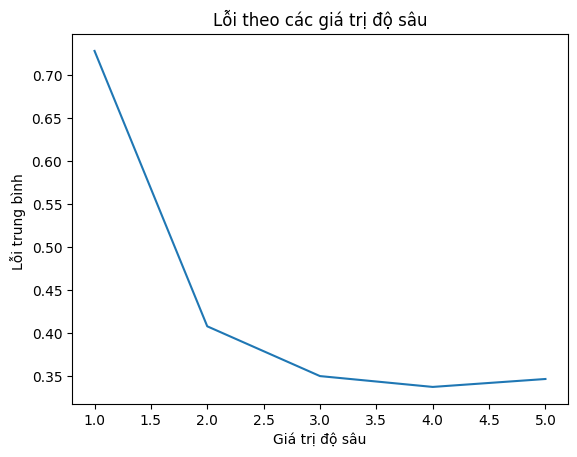

In [75]:
mse_test = np.mean((y_test - y_pred) ** 2)
print(f'Lỗi trung bình trên tập test (thủ công): {mse_test}')

# Vẽ biểu đồ lỗi theo độ sâu
plot_errors(depth_values[:len(errors)], errors)


*Giải thích*

*   Tính lỗi MSE trên tập kiểm tra: Mô hình dự đoán trên tập kiểm tra (X_test), sau đó bạn tính toán lỗi MSE giữa giá trị dự đoán và giá trị thực của tập kiểm tra.
*   Vẽ biểu đồ lỗi: Hàm plot.plot_errors được gọi để vẽ biểu đồ thể hiện lỗi MSE thay đổi theo từng độ sâu của cây quyết định. Điều này giúp bạn trực quan hóa quá trình tối ưu hóa độ sâu.





# 10. Huấn luyện mô hình với Scikit-learn:

Depth = 1, Average Fold Error = 0.7286371099806546
Depth = 2, Average Fold Error = 0.4065775620315509
Depth = 3, Average Fold Error = 0.3490147287960511
Depth = 4, Average Fold Error = 0.336748388521816
Depth = 5, Average Fold Error = 0.3497751746537241
Chênh lệch lỗi nhỏ hơn ngưỡng 0.01, dừng tại độ sâu 6.
Độ sâu tối ưu (sklearn): 4
Lỗi trung bình trên tập test (sklearn): 3.725746701769009


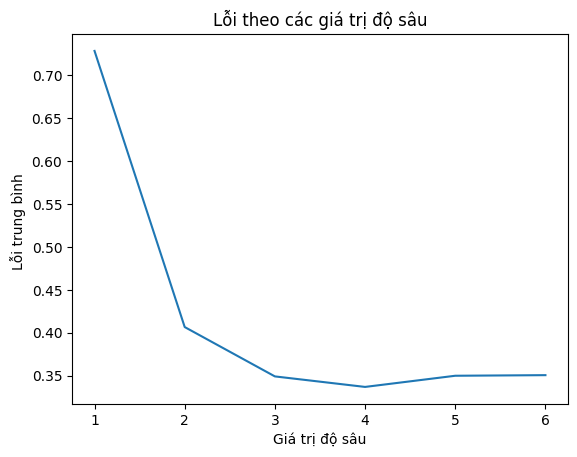

In [77]:
# 1. Thiết lập độ sâu cây cần kiểm tra và ngưỡng dừng
depth_values = range(1, 11)
threshold = 0.01  # Ngưỡng chênh lệch lỗi để dừng

# 2. Huấn luyện mô hình và tìm độ sâu tối ưu
errors = []
best_depth = None
lowest_error = float('inf')
previous_error = None  # Lưu lỗi của độ sâu trước đó

for depth in depth_values:
    fold_errors = []
    for fold in range(5):
        X_train, y_train, X_val, y_val = load_fold_data(fold)

        # Khởi tạo và huấn luyện Decision Tree bằng thư viện scikit-learn
        tree = DecisionTreeRegressor(max_depth=depth)
        tree.fit(X_train, y_train)

        # Dự đoán trên tập val
        y_pred = tree.predict(X_val)

        # Tính lỗi MSE
        mse = np.mean((y_val - y_pred) ** 2)
        fold_errors.append(mse)

    avg_error = np.mean(fold_errors)
    errors.append(avg_error)

    # Kiểm tra ngưỡng dừng
    if previous_error is not None and abs(previous_error - avg_error) < threshold:
        print(f"Chênh lệch lỗi nhỏ hơn ngưỡng {threshold}, dừng tại độ sâu {depth}.")
        break

    # Cập nhật độ sâu tối ưu nếu lỗi thấp hơn
    if avg_error < lowest_error:
        lowest_error = avg_error
        best_depth = depth

    previous_error = avg_error  # Cập nhật lỗi trước đó để kiểm tra ngưỡng

    print(f"Depth = {depth}, Average Fold Error = {avg_error}")

# 3. Lưu trữ mô hình với độ sâu tốt nhất
print(f'Độ sâu tối ưu (sklearn): {best_depth}')

# 4. Dự đoán trên tập test
X_train, y_train = load_data_from('D:/NgoChucNgoc64KTPM2/HocMayG3/Student-Final-Grade-ML/data/split/train_data.csv')
X_test, y_test = load_data_from('D:/NgoChucNgoc64KTPM2/HocMayG3/Student-Final-Grade-ML/data/split/train_data.csv')
tree = DecisionTreeRegressor(max_depth=best_depth)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

# 5. Tính lỗi và vẽ biểu đồ
mse_test = np.mean((y_test - y_pred) ** 2)
print(f'Lỗi trung bình trên tập test (sklearn): {mse_test}')

# Vẽ biểu đồ lỗi theo độ sâu
plot_errors(depth_values[:len(errors)], errors)





*   *Chi tiết từng bước:*

*   Huấn luyện mô hình: Sử dụng DecisionTreeRegressor từ scikit-learn, mô hình được huấn luyện trên dữ liệu huấn luyện cho mỗi fold.

*   Tính lỗi MSE: Lỗi trung bình bình phương (MSE) được tính toán cho mỗi fold và lưu vào danh sách fold_errors.
*  Tính lỗi trung bình: Lỗi trung bình của tất cả các fold được tính toán và lưu vào danh sách errors.


*   Kiểm tra ngưỡng dừng: Nếu chênh lệch giữa lỗi trung bình của độ sâu hiện tại và độ sâu trước đó nhỏ hơn ngưỡng cho phép, quá trình huấn luyện sẽ dừng lại.






# 11. So sánh Mô hình Tự xây dựng và Scikit-learn

*  *Nhận xét*

* Cả hai mô hình đều chọn độ sâu tối ưu là 4, cho thấy chúng có hiệu suất tương đương trong việc học từ dữ liệu.

*  Lỗi trung bình trên tập test của cả hai mô hình là giống nhau, ở mức 3.7257. Điều này cho thấy cả hai mô hình đều có khả năng dự đoán tương đương khi áp dụng trên tập test.

*  Các lỗi trung bình theo từng độ sâu cũng tương tự nhau, cho thấy rằng cả hai mô hình đều đang tối ưu hóa tốt theo độ sâu cây. Mô hình Scikit-learn có vẻ như cung cấp một số lỗi thấp hơn ở độ sâu 2 và 3, nhưng sự khác biệt không đáng kể.
*  Mô hình tự xây dựng dừng lại ở độ sâu 4, trong khi mô hình Scikit-learn có thể kiểm tra độ sâu 5 và dừng ở độ sâu 6.

*   ***Kết luận: Kết quả cho thấy rằng mô hình tự xây dựng của bạn và mô hình Scikit-learn đạt được hiệu suất tương đương, mặc dù mô hình Scikit-learn có lợi thế về việc xử lý các điều kiện dừng và kiểm tra thêm độ sâu cây.***








